In [4]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import libdatasets
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

In [5]:
import joblib

In [6]:
def noise(X_train, X_test, y_train, y_test, amount=1e-1, rand=None, config_str=None, i=None):
    n = int(y_train.shape[0]*amount)
    idx = rand.randint(0, y_train.shape[0], n)
    replacements = rand.choice(np.unique(y_train), n)
    if config_str is not None:
        joblib.dump({"idx": idx, "X": X_train[idx], "y": y_train[idx], "replacement": replacements}, f"mutator_log/{config_str}_{i}.joblib")
    y_train[idx] = replacements
    return X_train, X_test, y_train, y_test

In [11]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("car", lambda: lru_cache()(car)()),
        ("german", lambda: lru_cache()(german)()),
        #("mnist", lambda: lru_cache()(mnist)(1000)),
        #("quickdraw", lambda: lru_cache()(quickdraw)(1000)),
    ],
    "dataset_mutators": {
        #"none": (lambda *x, **kwargs: x),
        "noise": noise,
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 10,
        "ret_classifiers": True,
    }
}

In [12]:
results = librun.run(matrix, force_cache=True)

In [13]:
plots = [result[0] for result in results]
classifiers = [result[1] for result in results]

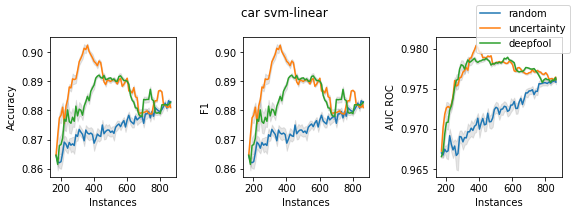

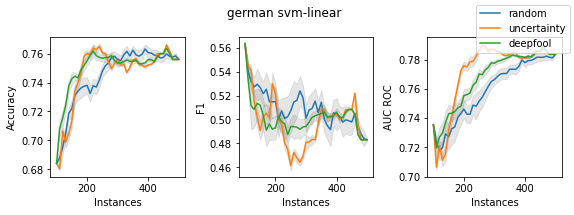

In [19]:
reload(librun); librun.plot(plots, figsize=(8,3))

In [17]:
log = joblib.load('mutator_log/car__noise__deepfool__svm-linear__dataset_size=1000__labelled_size=0.1__n_runs=10__ret_classifiers=True_4.joblib')

In [70]:
query_log = [clf.X_training for clf in classifiers[1][4]]
noisy = log['X']

In [71]:
when = [-1] * len(noisy)
for i, noise in enumerate(noisy):
    for ii in range(len(query_log)):
        #print(noise, query_log[ii])
        if np.any(np.all(noise==query_log[ii],axis=1)):
            when[i] = ii
            break

In [72]:
np.mean([x for x in when if x != 0])

32.76923076923077

In [78]:
np.unique([x for x in when if x != 0], return_counts=True)

(array([ 1,  2,  3,  4,  5,  7, 10, 13, 14, 16, 17, 18, 19, 20, 25, 28, 32,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 55, 56, 60, 61,
        62, 65]),
 array([1, 2, 1, 3, 1, 2, 3, 1, 3, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
        2, 2, 1, 1, 2, 2, 1, 3, 2, 1, 3, 1, 3, 2], dtype=int64))

In [73]:
len(query_log)/2

35.5

In [76]:
classifiers[1][4][0]

ActiveLearner(X_training=array([[1, 3, 4, ..., 3, 3, 1],
       [2, 3, 5, ..., 3, 2, 0],
       [3, 1, 3, ..., 1, 1, 0],
       ...,
       [1, 2, 2, ..., 3, 1, 1],
       [2, 2, 2, ..., 3, 2, 1],
       [3, 2, 5, ..., 1, 3, 1]], dtype=int64),
              bootstrap_init=None,
              estimator=SVC(kernel='linear', probability=True),
              query_strategy=functools.partial(<function uncertainty_batch_sampling at 0x0000028FCFF46B80>, n_instances=10),
              y_training=array([...
       'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc',
       'vgood', 'vgood', 'unacc', 'acc', 'unacc', 'good', 'unacc',
       'unacc', 'acc', 'unacc', 'unacc', 'unacc', 'unacc', 'acc', 'unacc',
       'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc', 'unacc',
       'acc', 'vgood', 'unacc', 'unacc', 'acc', 'unacc', 'unacc', 'unacc',
       'unacc', 'unacc', 'good', 'good', 'unacc', 'unacc', 'unacc',
       'unacc', 'unacc', 'acc', 'acc'], dtype=object))